<a href="https://colab.research.google.com/github/ubermenchh/learnpytorch/blob/main/stanford_spiral_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ubermenchh/learnpytorch.git
%cd learnpytorch

Cloning into 'learnpytorch'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 29 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (29/29), 773.51 KiB | 11.72 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/learnpytorch/learnpytorch


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

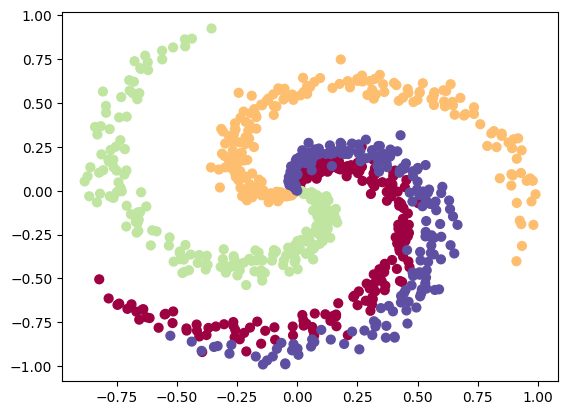

In [5]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [6]:
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.LongTensor)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)

(640, 160, 640, 160)

In [9]:
class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
model = Model(in_features=D, out_features=K, hidden_units=8).to(device)
model

Model(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.03)

In [13]:
X_train.shape

torch.Size([640, 2])

In [14]:
y_logits = model(X_train.to(device))
y_logits[:5]

tensor([[0.1170, 0.2133, 0.0969, 0.3620],
        [0.1374, 0.2128, 0.1110, 0.3665],
        [0.1550, 0.2173, 0.1084, 0.3564],
        [0.1699, 0.2390, 0.0937, 0.3308],
        [0.1515, 0.2662, 0.0734, 0.3329]], grad_fn=<SliceBackward0>)

In [15]:
y_pred_prob = torch.softmax(y_logits, dim=1)[:5]
y_pred = y_pred_prob.argmax(dim=1)

In [16]:
accuracy_fn(y_test.to(device)[:5], y_pred)

20.0

In [17]:
epochs = 10000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    logits = model(X_train)
    preds = torch.softmax(logits, dim=1).argmax(dim=1)
    loss = loss_fn(logits, y_train)
    acc = accuracy_fn(y_train, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch 0: Loss: 1.39293 | Accuracy: 25.78% | Test Loss: 1.40499 | Test Accuracy: 21.88%
Epoch 1000: Loss: 1.02981 | Accuracy: 41.88% | Test Loss: 1.05670 | Test Accuracy: 43.75%
Epoch 2000: Loss: 0.95466 | Accuracy: 45.94% | Test Loss: 0.98665 | Test Accuracy: 48.75%
Epoch 3000: Loss: 0.85394 | Accuracy: 52.97% | Test Loss: 0.88541 | Test Accuracy: 50.00%
Epoch 4000: Loss: 0.73817 | Accuracy: 63.75% | Test Loss: 0.77183 | Test Accuracy: 55.62%
Epoch 5000: Loss: 0.65481 | Accuracy: 71.09% | Test Loss: 0.68244 | Test Accuracy: 63.12%
Epoch 6000: Loss: 0.59173 | Accuracy: 74.22% | Test Loss: 0.60983 | Test Accuracy: 70.62%
Epoch 7000: Loss: 0.53477 | Accuracy: 79.06% | Test Loss: 0.55099 | Test Accuracy: 76.88%
Epoch 8000: Loss: 0.46097 | Accuracy: 83.59% | Test Loss: 0.48061 | Test Accuracy: 84.38%
Epoch 9000: Loss: 0.37394 | Accuracy: 87.03% | Test Loss: 0.37427 | Test Accuracy: 88.12%


In [18]:
from helper_functions import plot_decision_boundary

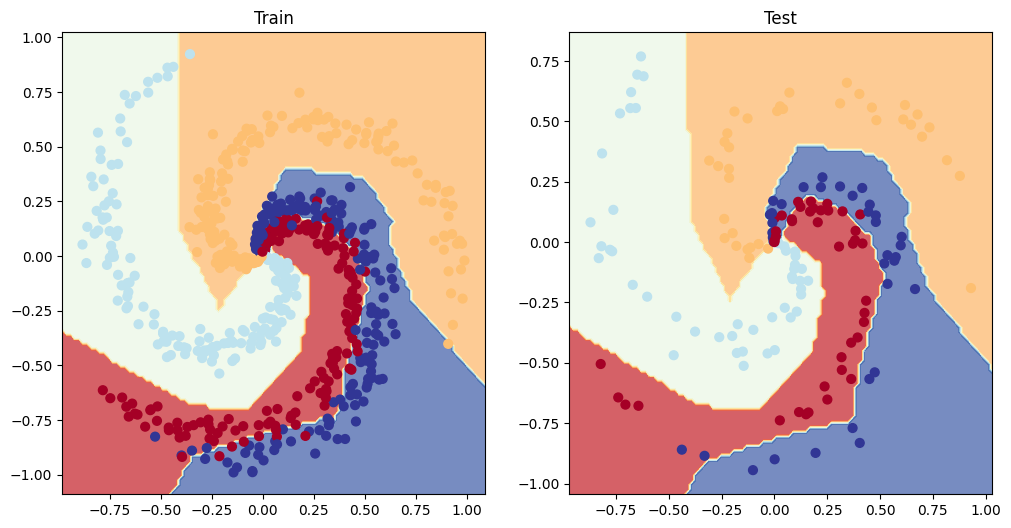

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)